In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import glob
import os
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Read Datasets

In [2]:
path = os.getcwd()
path = os.path.join(path,'dataset')

file_list = glob.glob(path+'/*csv')
names = [text.split("/")[-1].split(".")[0] for text in file_list]

for file,name in zip(file_list,names):
    df = pd.read_csv(file)
    globals()[f'{name}'] = df



### Exploratory Data Analysis (EDA)

Client Data

In [3]:
client_data.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,t,0.00,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,f,0.00,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,f,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,f,0.00,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,f,52.32,44.91,44.91,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0


In [4]:
client_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14606 non-null  object 
 1   channel_sales                   14606 non-null  object 
 2   cons_12m                        14606 non-null  int64  
 3   cons_gas_12m                    14606 non-null  int64  
 4   cons_last_month                 14606 non-null  int64  
 5   date_activ                      14606 non-null  object 
 6   date_end                        14606 non-null  object 
 7   date_modif_prod                 14606 non-null  object 
 8   date_renewal                    14606 non-null  object 
 9   forecast_cons_12m               14606 non-null  float64
 10  forecast_cons_year              14606 non-null  int64  
 11  forecast_discount_energy        14606 non-null  float64
 12  forecast_meter_rent_12m         

In [5]:
client_data.describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn
count,1.460600e+04,1.460600e+04,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,1.592203e+05,2.809238e+04,16090.269752,1868.614880,1399.762906,0.966726,63.086871,0.137283,0.050491,43.130056,152.786896,24.565121,24.562517,1.292346,189.264522,4.997809,18.135136,0.097152
std,5.734653e+05,1.629731e+05,64364.196422,2387.571531,3247.786255,5.108289,66.165783,0.024623,0.049037,4.485988,341.369366,20.231172,20.230280,0.709774,311.798130,1.611749,13.534743,0.296175
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,3.300000,0.000000
25%,5.674750e+03,0.000000e+00,0.000000,494.995000,0.000000,0.000000,16.180000,0.116340,0.000000,40.606701,0.000000,14.280000,14.280000,1.000000,50.712500,4.000000,12.500000,0.000000
50%,1.411550e+04,0.000000e+00,792.500000,1112.875000,314.000000,0.000000,18.795000,0.143166,0.084138,44.311378,37.395000,21.640000,21.640000,1.000000,112.530000,5.000000,13.856000,0.000000
75%,4.076375e+04,0.000000e+00,3383.000000,2401.790000,1745.750000,0.000000,131.030000,0.146348,0.098837,44.311378,193.980000,29.880000,29.880000,1.000000,243.097500,6.000000,19.172500,0.000000
max,6.207104e+06,4.154590e+06,771203.000000,82902.830000,175375.000000,30.000000,599.310000,0.273963,0.195975,59.266378,15042.790000,374.640000,374.640000,32.000000,24570.650000,13.000000,320.000000,1.000000


plotting features histogram to see distribution of the dataset

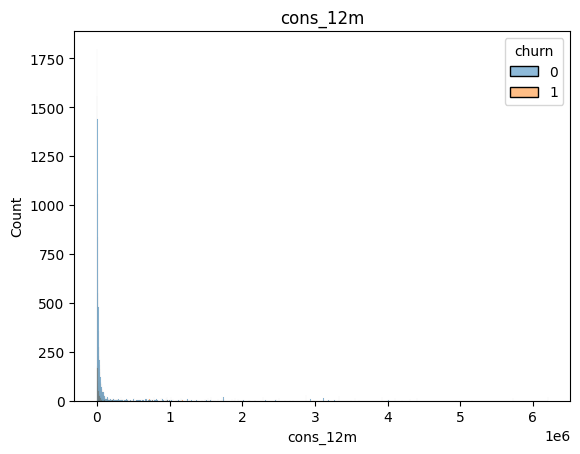

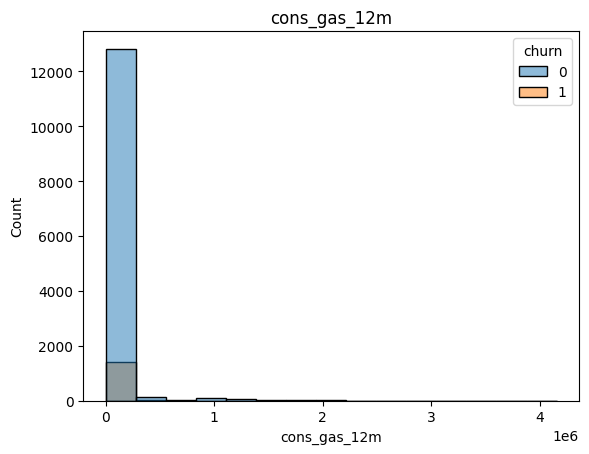

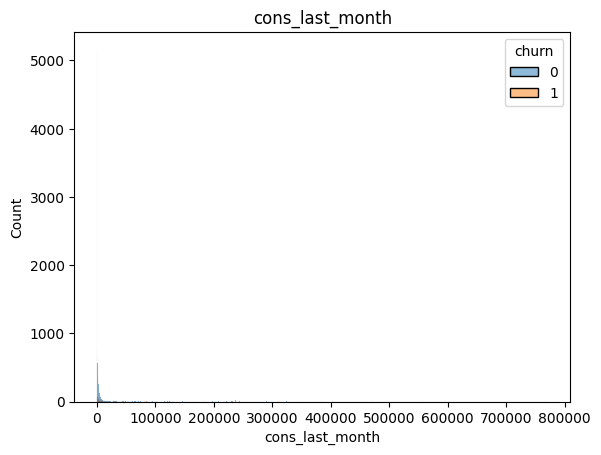

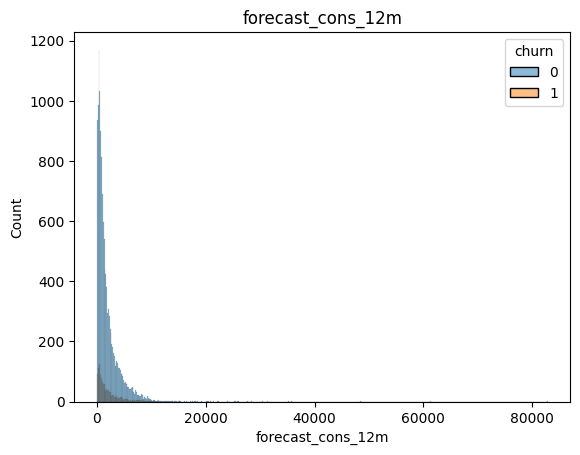

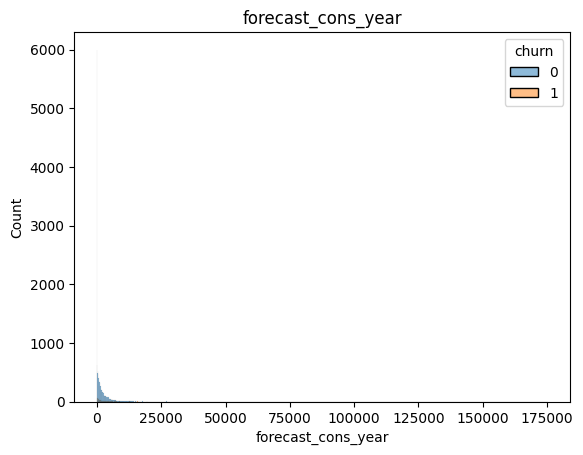

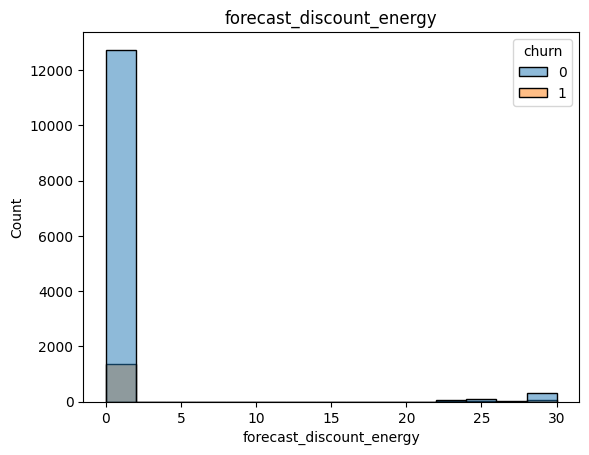

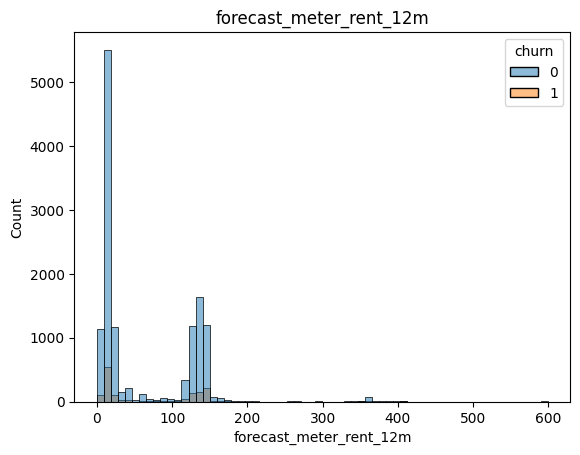

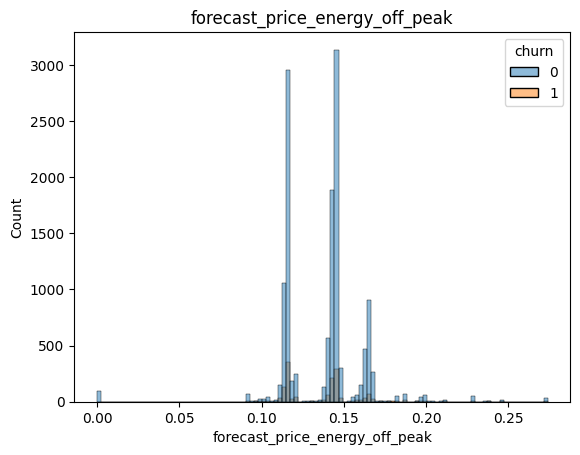

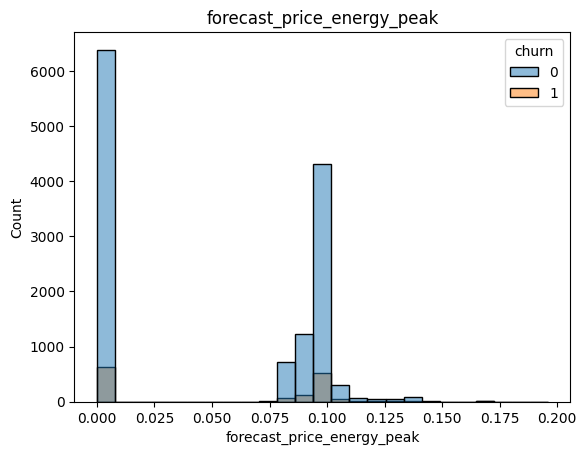

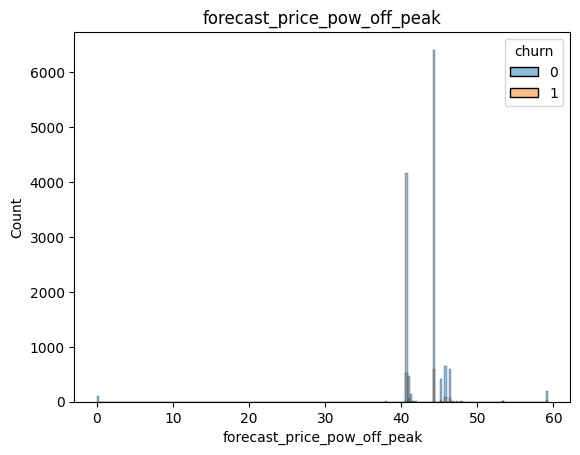

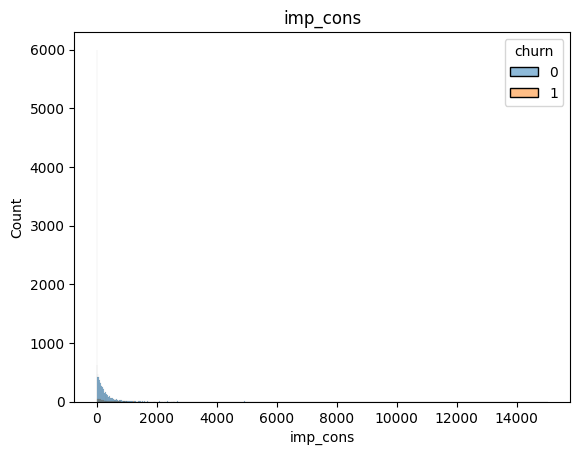

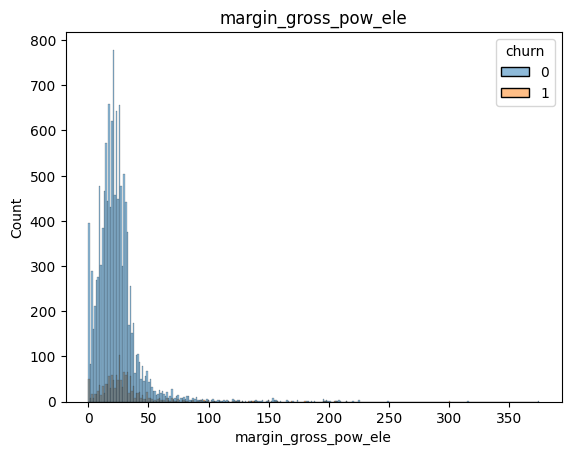

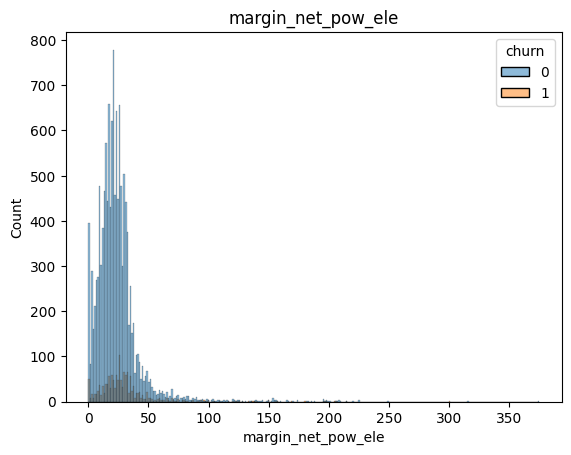

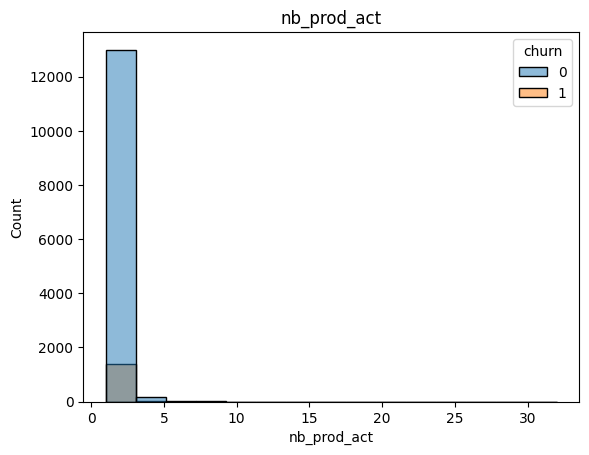

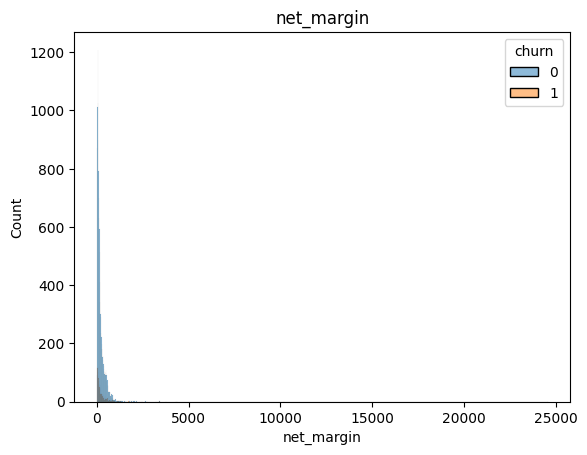

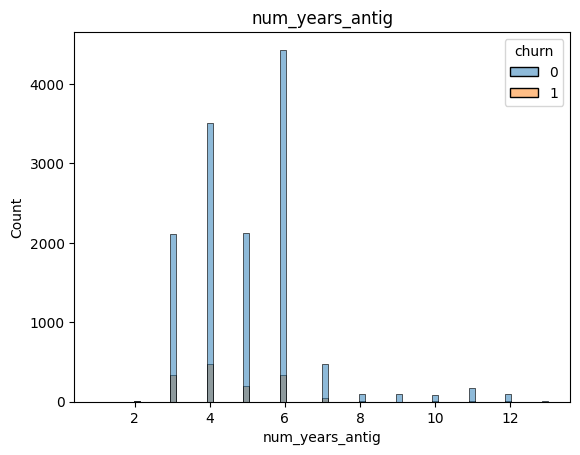

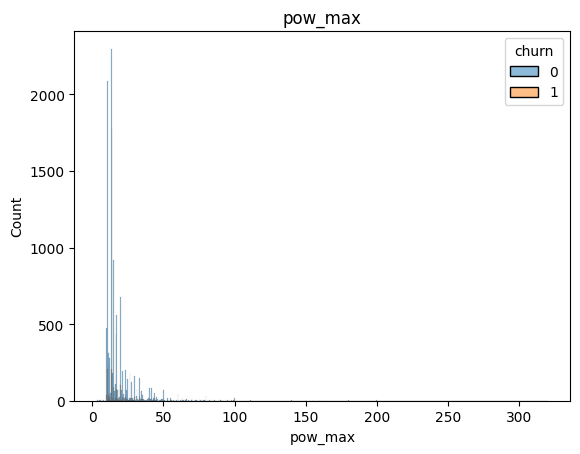

In [6]:
cont_features = client_data.select_dtypes(include=['int64','float64']).columns.tolist()
cont_features.remove("churn")
target = ['churn']

for feature in cont_features:
    sns.histplot(data=client_data,x=f"{feature}",hue="churn")
    plt.title(f"{feature}")
    plt.show()

Most of the dataset are skewed and not normal, this will be important to determine the next step on exploratory data analysis

Next we need to understand how many churned id on the data

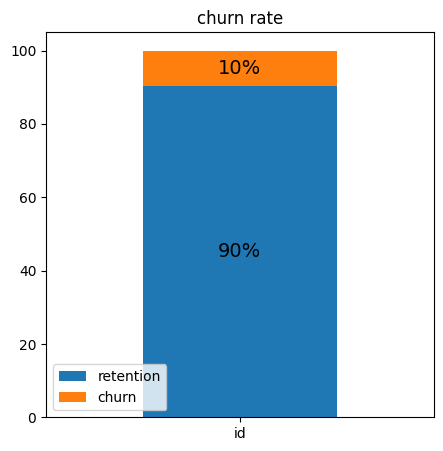

In [8]:
total_churn = client_data[["id"]].groupby(client_data["churn"]).count()
percentage_churn = total_churn/total_churn.sum()*100

fig,ax = plt.subplots(figsize=(5,5))
ax = percentage_churn.transpose().plot(kind="bar",stacked=True,rot=0,ax=ax)
ax.set_title("churn rate")

for rec in ax.patches:
    width,height = rec.get_width(),rec.get_height()
    x,y = rec.get_xy()
    ax.text(x + width/2, y + height/2, f'{height/100:.0%}', ha='center', va='center', fontsize=14)

ax.legend(["retention","churn"],loc="lower left")
plt.show()


around 10% of the customer have churned

Let's see how channel affect churn rate

In [9]:
price_data.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


merging price data with the available customer id

In [10]:
customer_data = client_data[["id","churn"]]
df_price = customer_data.merge(price_data,on="id")

## Analysis

Understanding price distribution

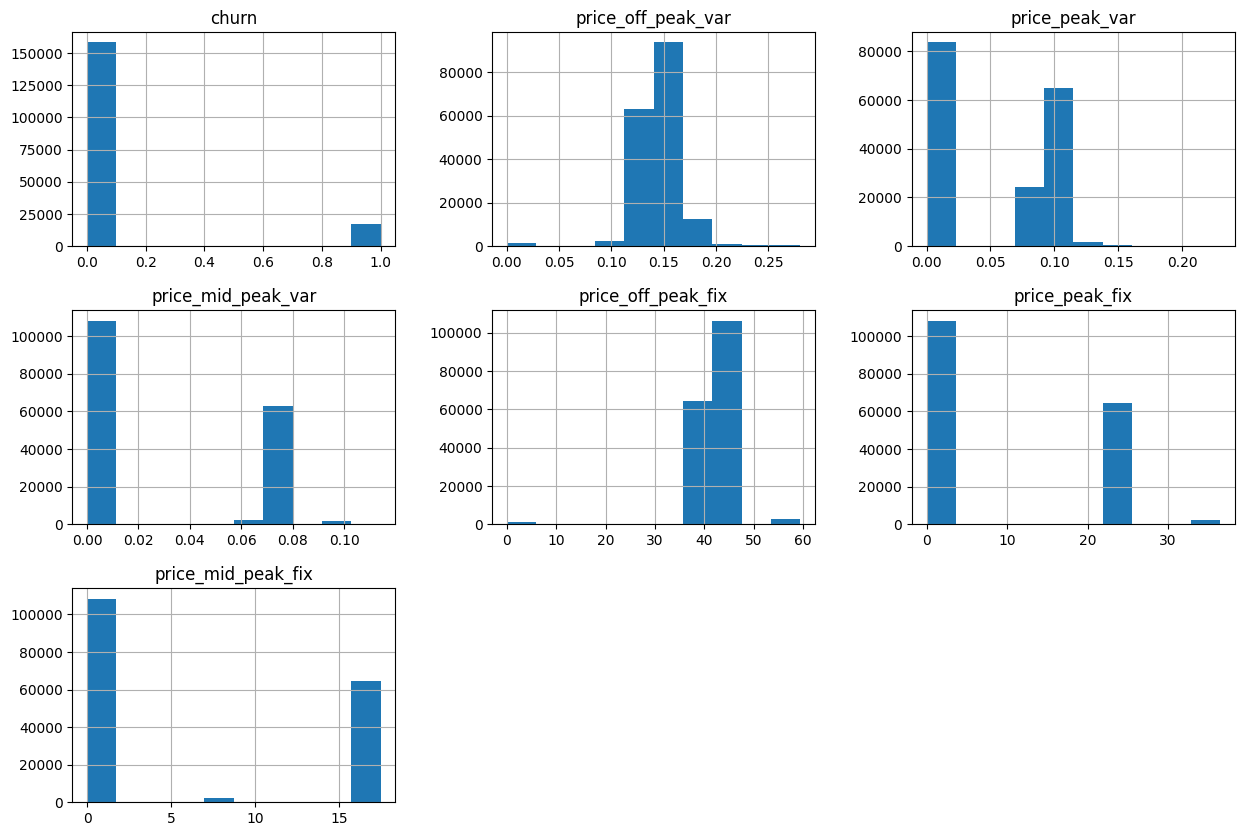

In [11]:
df_price.groupby(['id','price_date']).mean().hist(figsize=(15,10))
plt.show()

Data is skewed and imbalance

### Plotting energy and power price

In [12]:
churn_price = df_price[df_price["churn"] == 1].drop("id",axis=1).groupby(['price_date']).mean()
non_churn_price = df_price[df_price["churn"] == 0].drop("id",axis=1).groupby(['price_date']).mean()


Energy price

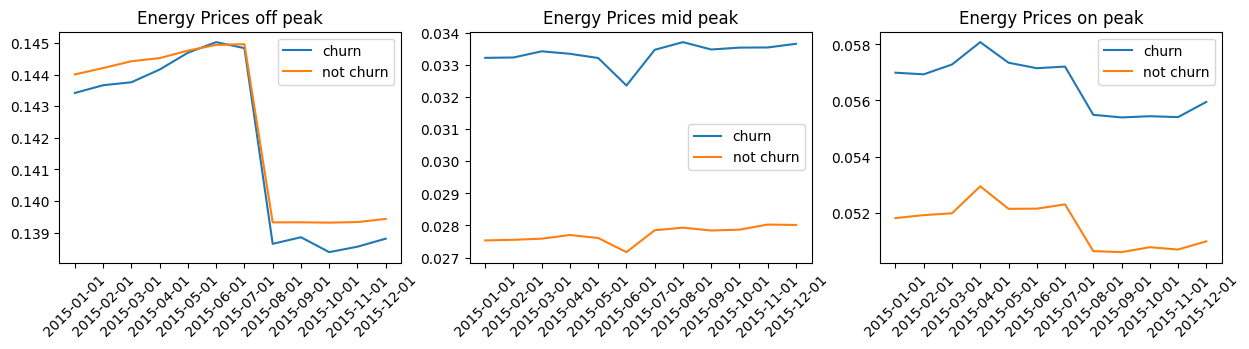

In [13]:
plt.figure(figsize=(15,3))
plt.subplot(131)
plt.xticks(rotation=45)
plt.plot(churn_price["price_off_peak_var"])
plt.plot(non_churn_price["price_off_peak_var"])
plt.legend(["churn","not churn"])
plt.xticks(rotation=45)
plt.title("Energy Prices off peak")
plt.subplot(132)
plt.plot(churn_price["price_mid_peak_var"])
plt.plot(non_churn_price["price_mid_peak_var"])
plt.legend(["churn","not churn"])
plt.xticks(rotation=45)
plt.title("Energy Prices mid peak")
plt.subplot(133)
plt.xticks(rotation=45)
plt.plot(churn_price["price_peak_var"])
plt.plot(non_churn_price["price_peak_var"])
plt.legend(["churn","not churn"])
plt.xticks(rotation=45)
plt.title("Energy Prices on peak")
plt.show()

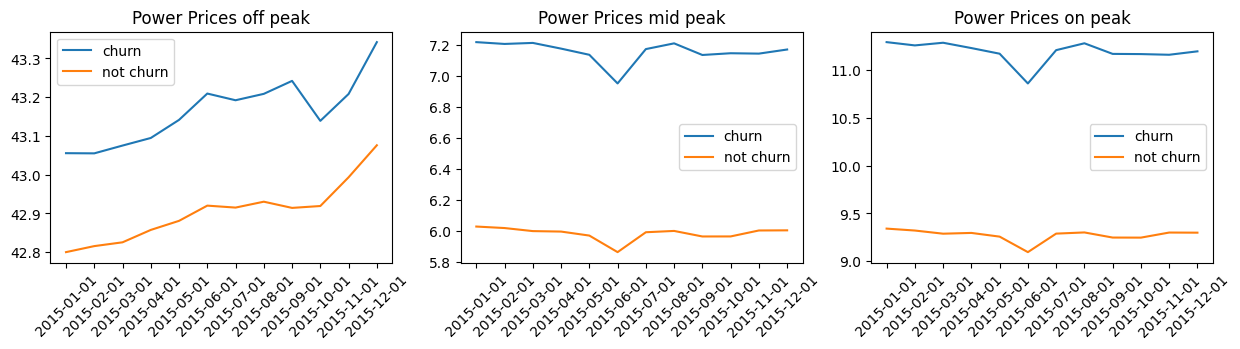

In [14]:
plt.figure(figsize=(15,3))
plt.subplot(131)
plt.xticks(rotation=45)
plt.plot(churn_price["price_off_peak_fix"])
plt.plot(non_churn_price["price_off_peak_fix"])
plt.legend(["churn","not churn"])
plt.xticks(rotation=45)
plt.title("Power Prices off peak")
plt.subplot(132)
plt.plot(churn_price["price_mid_peak_fix"])
plt.plot(non_churn_price["price_mid_peak_fix"])
plt.legend(["churn","not churn"])
plt.xticks(rotation=45)
plt.title("Power Prices mid peak")
plt.subplot(133)
plt.xticks(rotation=45)
plt.plot(churn_price["price_peak_fix"])
plt.plot(non_churn_price["price_peak_fix"])
plt.legend(["churn","not churn"])
plt.xticks(rotation=45)
plt.title("Power Prices on peak")
plt.show()

Interesting findings on off peak energy prices where churn price is slightly lower than non-churn prices all the year, while on others all churn prices are always higher than non-churn prices. Furthermore, only off peak prices that has high difference between beginning and end of the year, while the others show relatively constant prices throughout the year

let's try to see the correlation coefficient of the features if there is multicollinearity between the features

In [15]:
df_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175149 entries, 0 to 175148
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  175149 non-null  object 
 1   churn               175149 non-null  int64  
 2   price_date          175149 non-null  object 
 3   price_off_peak_var  175149 non-null  float64
 4   price_peak_var      175149 non-null  float64
 5   price_mid_peak_var  175149 non-null  float64
 6   price_off_peak_fix  175149 non-null  float64
 7   price_peak_fix      175149 non-null  float64
 8   price_mid_peak_fix  175149 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 12.0+ MB


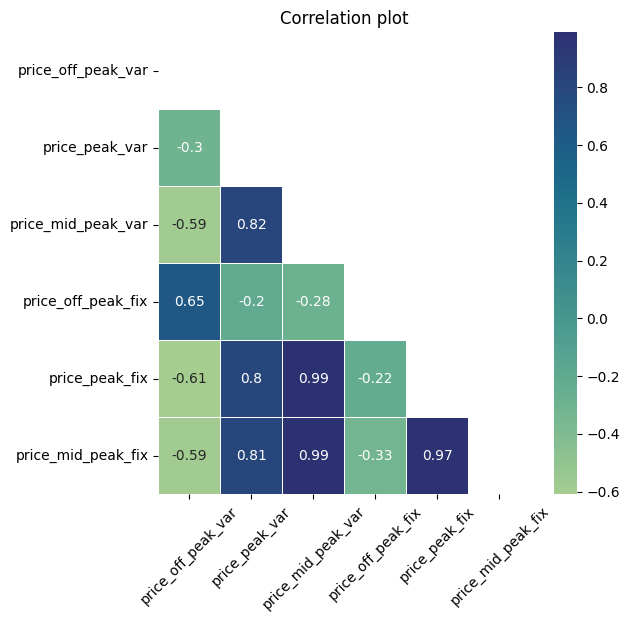

In [16]:
price_corr = df_price.drop(["id","churn","price_date"],axis=1).corr()
plt.figure(figsize=(6,6))
mask = np.triu(np.ones_like(price_corr))
sns.heatmap(price_corr,annot=True,cmap="crest",linewidths=0.5,mask=mask)
plt.xticks(rotation=45)
plt.title("Correlation plot")
plt.show()

High correlation features indicate features having similar information and could cause multicollinearity. It will be better to drop one of the features that has high correlation with other features

## Feature Engineering

Since the price data is monthly, we couldn't directly merge it to the client data. Therefore, we need to transform the information from price data to be derived into yearly format. We can take the average of monthly prices from mid peak and off peak energy and power prices as it follows a linear pattern. The energy off peak was high at the beginning and low at the end of the year thus we can take the price difference as the feature 

In [17]:
#Get jan and dec prices energy off peak
price_off_peak_energy = price_data[["id","price_date","price_off_peak_var"]]
price_off_peak_energy["price_date"] = price_off_peak_energy.price_date.astype("datetime64[ns]")
jan_prices = price_off_peak_energy.groupby("id")[["price_off_peak_var"]].first().reset_index().rename(columns={"price_off_peak_var":"price_off_peak_var_jan"})
dec_prices = price_off_peak_energy.groupby("id")[["price_off_peak_var"]].last().reset_index().rename(columns={"price_off_peak_var":"price_off_peak_var_dec"})

#get the mean price data
price_data.drop(columns=["price_off_peak_var","price_date"],inplace=True)
price_data = price_data.groupby("id").mean().reset_index()

#Calculating energy off peak difference
price_data = price_data.merge(jan_prices,on="id").merge(dec_prices,on="id")
price_data["energy_off_peak_diff"] = price_data["price_off_peak_var_jan"] - price_data["price_off_peak_var_dec"]
price_data.drop(["price_off_peak_var_jan","price_off_peak_var_dec"],axis=1,inplace=True)



In [18]:
price_data.head()

,id,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,energy_off_peak_diff
0,0002203ffbb812588b632b9e628cc38d,0.103794,0.073160,40.701732,24.421038,16.280694,0.006192
1,0004351ebdd665e6ee664792efc4fd13,0.000000,0.000000,44.385450,0.000000,0.000000,0.004104
2,0010bcc39e42b3c2131ed2ce55246e3c,0.000000,0.000000,45.319710,0.000000,0.000000,-0.050443
3,0010ee3855fdea87602a5b7aba8e42de,0.098292,0.069032,40.647427,24.388455,16.258971,0.010018
4,00114d74e963e47177db89bc70108537,0.000000,0.000000,44.266930,0.000000,0.000000,0.003994


let's merge features from price data into client data

In [19]:
df = client_data.merge(price_data,on='id')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14606 non-null  object 
 1   channel_sales                   14606 non-null  object 
 2   cons_12m                        14606 non-null  int64  
 3   cons_gas_12m                    14606 non-null  int64  
 4   cons_last_month                 14606 non-null  int64  
 5   date_activ                      14606 non-null  object 
 6   date_end                        14606 non-null  object 
 7   date_modif_prod                 14606 non-null  object 
 8   date_renewal                    14606 non-null  object 
 9   forecast_cons_12m               14606 non-null  float64
 10  forecast_cons_year              14606 non-null  int64  
 11  forecast_discount_energy        14606 non-null  float64
 12  forecast_meter_rent_12m         

The new merged df has a total of 14606 rows, while the aggregated price data have 16096 rows, that means there are 1490 missing data 

Now, let's try to clean the features. We have several object data that needs to be cleaned and prepare first

In [27]:
df.select_dtypes(include='object').columns

Index(['id', 'channel_sales', 'date_activ', 'date_end', 'date_modif_prod',
       'date_renewal', 'has_gas', 'origin_up'],
      dtype='object')

In [33]:
df.select_dtypes(include='object').head()

,id,channel_sales,date_activ,date_end,date_modif_prod,date_renewal,has_gas,origin_up
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,2013-06-15,2016-06-15,2015-11-01,2015-06-23,t,lxidpiddsbxsbosboudacockeimpuepw
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,2009-08-21,2016-08-30,2009-08-21,2015-08-31,f,kamkkxfxxuwbdslkwifmmcsiusiuosws
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,2010-04-16,2016-04-16,2010-04-16,2015-04-17,f,kamkkxfxxuwbdslkwifmmcsiusiuosws
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,2010-03-30,2016-03-30,2010-03-30,2015-03-31,f,kamkkxfxxuwbdslkwifmmcsiusiuosws
4,149d57cf92fc41cf94415803a877cb4b,MISSING,2010-01-13,2016-03-07,2010-01-13,2015-03-09,f,kamkkxfxxuwbdslkwifmmcsiusiuosws


We will check the channel sales and origin up first as it contains categorical data

In [36]:
print("unique values of channel sales:\n{}\nunique values of origin up:\n{}".format(
      df["channel_sales"].unique(),df["origin_up"].unique()))

unique values of channel sales:
['foosdfpfkusacimwkcsosbicdxkicaua' 'MISSING'
 'lmkebamcaaclubfxadlmueccxoimlema' 'usilxuppasemubllopkaafesmlibmsdf'
 'ewpakwlliwisiwduibdlfmalxowmwpci' 'epumfxlbckeskwekxbiuasklxalciiuu'
 'sddiedcslfslkckwlfkdpoeeailfpeds' 'fixdbufsefwooaasfcxdxadsiekoceaa']
unique values of origin up:
['lxidpiddsbxsbosboudacockeimpuepw' 'kamkkxfxxuwbdslkwifmmcsiusiuosws'
 'ldkssxwpmemidmecebumciepifcamkci' 'MISSING'
 'usapbepcfoloekilkwsdiboslwaxobdp' 'ewxeelcelemmiwuafmddpobolfuxioce']


Let's clean the dataset into a more readable feature values

In [40]:
channel_sales_mask = {
    'foosdfpfkusacimwkcsosbicdxkicaua':'channel_1',
    'MISSING':'missing',
    'lmkebamcaaclubfxadlmueccxoimlema':'channel_2', 
    'usilxuppasemubllopkaafesmlibmsdf':'channel_3',
    'ewpakwlliwisiwduibdlfmalxowmwpci':'channel_4', 
    'epumfxlbckeskwekxbiuasklxalciiuu':'channel_5',
    'sddiedcslfslkckwlfkdpoeeailfpeds':'channel_6',
    'fixdbufsefwooaasfcxdxadsiekoceaa':'channel_7'
}

origin_up_mask = {
    'lxidpiddsbxsbosboudacockeimpuepw':'origin_1',
    'kamkkxfxxuwbdslkwifmmcsiusiuosws':'origin_2',
    'ldkssxwpmemidmecebumciepifcamkci':'origin_3',
    'MISSING':'missing',
    'usapbepcfoloekilkwsdiboslwaxobdp':'origin_4',
    'ewxeelcelemmiwuafmddpobolfuxioce':'origin_5'
}

df.replace({'channel_sales':channel_sales_mask,'origin_up':origin_up_mask},inplace=True)
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,num_years_antig,origin_up,pow_max,churn,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,energy_off_peak_diff
0,24011ae4ebbe3035111d65fa7c15bc57,channel_1,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,3,origin_1,43.648,1,0.100749,0.066530,40.942265,22.352010,14.901340,-0.020057
1,d29c2c54acc38ff3c0614d0a653813dd,missing,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,6,origin_2,13.800,0,0.007124,0.000000,44.311375,0.000000,0.000000,0.003767
2,764c75f661154dac3a6c254cd082ea7d,channel_1,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,6,origin_2,13.856,0,0.088421,0.000000,44.385450,0.000000,0.000000,0.004670
3,bba03439a292a1e166f80264c16191cb,channel_2,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,6,origin_2,13.200,0,0.000000,0.000000,44.400265,0.000000,0.000000,0.004547
4,149d57cf92fc41cf94415803a877cb4b,missing,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,6,origin_2,19.800,0,0.103638,0.072865,40.688156,24.412893,16.275263,0.006192


Now let's change the date data into datetime types and add a new feature to calculate days between the datetimes to see how many days they're having the services, renewed their contracts or modified their service